In [7]:
import pandas as pd


ds_json = pd.read_json('data/lorawan_antwerp_2019_dataset.json')
gw_loc = pd.read_json('data/lorawan_antwerp_gateway_locations.json')

In [50]:
# Loading initial position coordinates form machine learning predictions
pos_pred_rssi = pd.read_csv('files/position_pred_RSSI.csv', index_col=0)
pos_pred_comb = pd.read_csv('files/position_pred_weather-comb.csv', index_col=0)

import pymap3d as pm 

ref_pos = {'lat0': 51.260644,
           'lon0': 4.370656,
           'h0': 0}

# pos_pred_rssi['x'], pos_pred_rssi['y'], pos_pred_rssi['z'] = pm.geodetic2ecef(lat=pos_pred_rssi['lat'], lon=pos_pred_rssi['lon'], alt=0)
# pos_pred_rssi['x_i'], pos_pred_rssi['y_i'], pos_pred_rssi['z_i'] = pm.geodetic2ecef(lat=pos_pred_rssi['pred_lat_rssi'], lon=pos_pred_rssi['pred_lon_rssi'], alt=0)

# pos_pred_comb['x'], pos_pred_comb['y'], pos_pred_comb['z'] = pm.geodetic2ecef(lat=pos_pred_comb['lat'], lon=pos_pred_comb['lon'], alt=0)
# pos_pred_comb['x_i'], pos_pred_comb['y_i'], pos_pred_comb['z_i'] = pm.geodetic2ecef(lat=pos_pred_comb['pred_lat_comb'], lon=pos_pred_comb['pred_lon_comb'], alt=0)


pos_pred_rssi['x'], pos_pred_rssi['y'], pos_pred_rssi['z'] = pm.geodetic2enu(lat=pos_pred_rssi['lat'], lon=pos_pred_rssi['lon'], h=0, **ref_pos)
pos_pred_rssi['x_i'], pos_pred_rssi['y_i'], pos_pred_rssi['z_i'] = pm.geodetic2enu(lat=pos_pred_rssi['pred_lat_rssi'], lon=pos_pred_rssi['pred_lon_rssi'], h=0, **ref_pos)

pos_pred_comb['x'], pos_pred_comb['y'], pos_pred_comb['z'] = pm.geodetic2enu(lat=pos_pred_comb['lat'], lon=pos_pred_comb['lon'], h=0, **ref_pos)
pos_pred_comb['x_i'], pos_pred_comb['y_i'], pos_pred_comb['z_i'] = pm.geodetic2enu(lat=pos_pred_comb['pred_lat_comb'], lon=pos_pred_comb['pred_lon_comb'], h=0, **ref_pos)


The idea is to <input type="checkbox" enabled> accumulate the actual lat-lon data, predicted ones, the converted lat-lon values, including the lat-lon vlaues for initialization (these initial values are the converted location values predicted by the machine learning model) into a single dataframe and file.

Later

<input type="checkbox" enabled> 1. we will pick each sample from this locaiton dataset, 

<input type="checkbox" enabled> 2. take the timestamp values from the sample 

<input type="checkbox" enabled> 3. Find the corresponding data point from the ds_json raw data collection 

<input type="checkbox" enabled> 4. Get the corresponding GW metadata from the Gateways column

<input type="checkbox" enabled> 5. collect the TOA values for each GW and their GWID

<input type="checkbox" enabled> 6. We will get the lat-lon of the corresponding GW in the gw_loc df and convert it to ecef 

<input type="checkbox" enabled> 7. Do the position estimation

<input type="checkbox" enabled> 8. Compare the ecef coordinates with the actual values 

<input type="checkbox" enabled> 9. Finally, convert to the geodetic coordinate and calculate the defference/error '   


In [51]:
pos_pred_rssi.to_csv('files/pos_pred_rssi_ecef.csv')
pos_pred_comb.to_csv('files/pos_pred_comb_ecef.csv')

In [53]:
import numpy as np


# Collecting GW coordinates
def get_gw_cord_tdoa(index, ds_json, gw_loc):
    gw_ids = []
    toa = []
    gw_meta = ds_json.loc[index, ['gateways']]
    for gws in gw_meta:
        for gw in gws:
            gw_ids.append(gw['id'])
            toa.append(gw['rx_time']['time'])

    print(f'Receiving gateways: {gw_ids}')
    print(f'Time of arrivals: {toa}')
    
    gw_pos = []

    for i in gw_ids:
        gw = gw_loc[i]
        x, y, z = pm.geodetic2enu(lat=gw['latitude'], lon=gw['longitude'], h=0, **ref_pos)
        gw_pos.append([x,y,z])
    gw_positions = np.asarray(gw_pos)

    print('Gateway coordinates (ecef): ')
    print(gw_positions)

    # Calulating TDoA value
    # We use the pandas timestamp method in this case, 
    # because it is the only one that can handle precision upto nano second  
    tdoa = []
    for i in range(len(toa)):
        diff = (pd.Timestamp(toa[0])-pd.Timestamp(toa[i])).value
        # tdoa.append(abs(diff))
        tdoa.append(diff)
    print(f'Time difference of arrival: {tdoa}') 

    return toa, gw_positions, tdoa

get_gw_cord_tdoa(127217, ds_json, gw_loc)

Receiving gateways: ['080E00B9', 'FF01072B', 'FF01753E']
Time of arrivals: ['2019-01-18T08:06:49.058+01:00', '2019-01-18T08:06:49.942733360+01:00', '2019-01-18T08:06:49.942734458+01:00']
Gateway coordinates (ecef): 
[[ 3.42950136e+03 -7.28623463e+03 -5.08444638e+00]
 [ 3.92258394e+03 -7.27064010e+03 -5.35025029e+00]
 [ 2.51986817e+03 -7.02576446e+03 -4.36865519e+00]]
Time difference of arrival: [0, -884733360, -884734458]


(['2019-01-18T08:06:49.058+01:00',
  '2019-01-18T08:06:49.942733360+01:00',
  '2019-01-18T08:06:49.942734458+01:00'],
 array([[ 3.42950136e+03, -7.28623463e+03, -5.08444638e+00],
        [ 3.92258394e+03, -7.27064010e+03, -5.35025029e+00],
        [ 2.51986817e+03, -7.02576446e+03, -4.36865519e+00]]),
 [0, -884733360, -884734458])

## Foy's algorithm  

    Estimates the position using TDOA and Taylor-series estimation.
    
    Parameters:
    - initial_coords: Initial guess for the target node's coordinates [x, y].
    - gateway_coords: Coordinates of the gateways as a list of [x, y] pairs.
    - tdoa_values: Measured TDOA values between each pair of gateways.
    - max_iterations: Maximum number of iterations for convergence.
    - tolerance: Convergence tolerance for the position updates.
    
    Returns:
    - Estimated coordinates [x, y].

### Example usage:
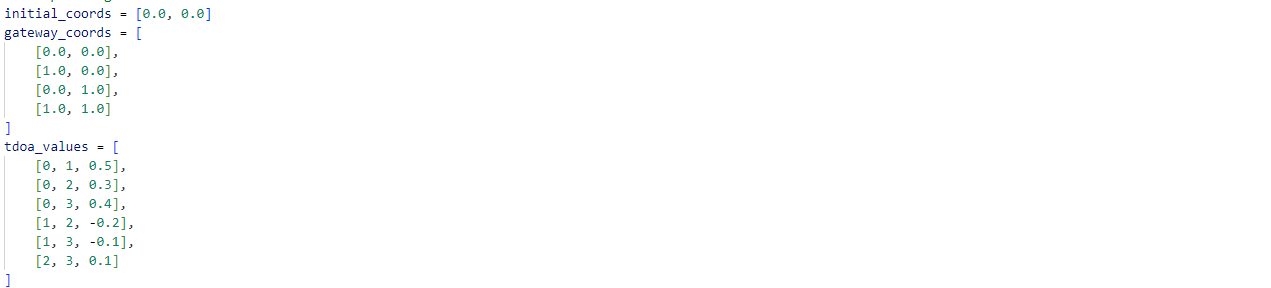

In [11]:
# from foys_alg import tdoa_position_estimation

for i in range(len(pos_pred_comb)):
    current_sample = pos_pred_comb.iloc[i] 
    # collecting the initial coorinates for estiamtion. These initial coordinates are the prediction of our ML model  
    init_cord = [current_sample['x_i'], current_sample['y_i']]

    # Collecting the GW coordinates  
    # getting the corresponding sample from ds_json: matching with the actual coordinates from the location data
    raw_data_sample = ds_json[(ds_json['latitude']==current_sample['lat']) & (ds_json['longitude']==current_sample['lon'])]
    
    

    # foy_estimation = tdoa_position_estimation(init_cord,  )

In [55]:
from chans_algorithm import chan_algorithm

toa, gw_pos1, tdoa = get_gw_cord_tdoa(84169, ds_json, gw_loc)

tdoa.pop(0)
gw_pos = np.delete(gw_pos1, 2, axis=1)
 
estimated_pos = chan_algorithm(gw_pos, tdoa)

Estimated Position:  [-0.4775  -0.39875]
Receiving gateways: ['FF0178DF', '080E0116', '08060716', 'FF01753E']
Time of arrivals: ['2018-12-31T08:49:13.832705509+01:00', '2018-12-31T08:49:13.944+01:00', '2018-12-31T08:49:13.949+01:00', '2018-12-31T08:49:13.832710481+01:00']
Gateway coordinates (ecef): 
[[ 1.73193814e+03 -6.53513544e+03 -3.58467373e+00]
 [ 6.97356078e+02 -7.32894077e+03 -4.25131073e+00]
 [ 1.94347883e+03 -6.10173267e+03 -3.21589629e+00]
 [ 2.51986817e+03 -7.02576446e+03 -4.36865519e+00]]
Time difference of arrival: [0, -111294491, -116294491, -4972]


In [12]:
row = pos_pred_comb[pos_pred_comb['gw_ref']==84169]
init_pos = [row['x_i'], row['y_i']]
# pos_pred_rssi

In [14]:
from foys_alg import tdoa_position_estimation


In [57]:
toa, gw_pos1, _ = get_gw_cord_tdoa(84169, ds_json, gw_loc)

gw_pos = np.delete(gw_pos1, 2, axis=1)

row = pos_pred_comb[pos_pred_comb['gw_ref']==84169]

init_pos = [row['x_i'], row['y_i']]


Receiving gateways: ['FF0178DF', '080E0116', '08060716', 'FF01753E']
Time of arrivals: ['2018-12-31T08:49:13.832705509+01:00', '2018-12-31T08:49:13.944+01:00', '2018-12-31T08:49:13.949+01:00', '2018-12-31T08:49:13.832710481+01:00']
Gateway coordinates (ecef): 
[[ 1.73193814e+03 -6.53513544e+03 -3.58467373e+00]
 [ 6.97356078e+02 -7.32894077e+03 -4.25131073e+00]
 [ 1.94347883e+03 -6.10173267e+03 -3.21589629e+00]
 [ 2.51986817e+03 -7.02576446e+03 -4.36865519e+00]]
Time difference of arrival: [0, -111294491, -116294491, -4972]


In [59]:
gw_pos1

array([[ 1.73193814e+03, -6.53513544e+03, -3.58467373e+00],
       [ 6.97356078e+02, -7.32894077e+03, -4.25131073e+00],
       [ 1.94347883e+03, -6.10173267e+03, -3.21589629e+00],
       [ 2.51986817e+03, -7.02576446e+03, -4.36865519e+00]])

In [56]:
import pandas as pd
from itertools import combinations

toa = ['2018-12-31T08:49:13.832705509+01:00', '2018-12-31T08:49:13.944+01:00', '2018-12-31T08:49:13.949+01:00', '2018-12-31T08:49:13.832710481+01:00']

tdoa = []
# Generate unique pairs using combinations
for i, j in combinations(range(len(toa)), 2):
    diff = pd.Timestamp(toa[i]).value - pd.Timestamp(toa[j]).value
    diff_seconds = diff*10e-9
    tdoa.append([i, j, diff_seconds])
print(f'Time difference of arrival: {tdoa}')


Time difference of arrival: [[0, 1, -0.11129449100000001], [0, 2, -0.11629449100000001], [0, 3, -4.972e-06], [1, 2, -0.005], [1, 3, 0.111289519], [2, 3, 0.11628951900000001]]


In [17]:
pos_est = tdoa_position_estimation(init_pos, gw_pos, tdoa)


ValueError: non-broadcastable output operand with shape (2,1) doesn't match the broadcast shape (2,2)

In [42]:
toa = ['2018-12-31T08:49:13.832705509+01:00', '2018-12-31T08:49:13.944+01:00', '2018-12-31T08:49:13.949+01:00', '2018-12-31T08:49:13.832710481+01:00']

tdoa

[[0, 1, -0.11129449100000001],
 [0, 2, -0.11629449100000001],
 [0, 3, -4.972e-06],
 [1, 2, -0.005],
 [1, 3, 0.111289519],
 [2, 3, 0.11628951900000001]]

In [60]:
est_pos = [-1.2833209633143689e+23, 1.6510432431760755e+23]

pm.enu2geodetic(e=est_pos[0], n=est_pos[1], u=0, **ref_pos)

(29.609114590329654, -130.72948929384557, 2.0911376056394503e+23)